In [12]:
import matplotlib as mpl

font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe

import numpy as np
import json
import glob, os
from cmcrameri import cm
from proteus.atmos_clim.common import read_ncdf_profile


In [13]:
def read_json(fpath):
    with open(fpath) as hdl:
        data = json.load(hdl)
    
    out = {}
    for k in data["data"].keys():
        arr = [float(v) for v in data["data"][k]["values"]]
        out[k] = np.array(arr, dtype=float) * float(data["data"][k]["scaling"])

    out["time"]  = float(data["time_years"])
    out["rfidx"] = int(data["rheological_front_phi"]["mesh_index"]["values"][0])
    return out

In [14]:
output_dir = "data/article_data/jgr_proteus_grid/fiducial/"
tmin = 100

In [15]:
%matplotlib inline

In [16]:
# Gather data files
output_files = glob.glob(output_dir+"/data/*_atm.nc")
output_times = [ int(str(f).split('/')[-1].split('_')[0]) for f in output_files]
sort_mask = np.argsort(output_times)
atm_files = np.array(output_files)[sort_mask]
atm_times = np.array(output_times)[sort_mask]

# Parse NetCDF and JSON files
stride = 1
atm_p = [] # pressure
atm_t = [] # temperature
atm_z = [] # height 
int_p = [] # pressure
int_t = [] # temperature 
int_m = [] # melt fraction
int_f = [] # rheo front mesh index
times = [] # model time
for i in range(0,len(atm_files),stride):
    time = atm_times[i]
    if time < tmin:
        continue
    times.append(atm_times[i]/1e6)

    prof = read_ncdf_profile(atm_files[i])
    atm_p.append(prof["p"] / 1.0e5)  # Convert Pa -> bar
    atm_t.append(prof["t"])
    atm_z.append(prof["z"] / 1.0e3)  # Convert m -> km


    fpath = str(atm_files[i]).replace("_atm.nc",".json")
    prof = read_json(fpath)
    int_p.append(prof["pressure_b"]/1e9)
    int_t.append(prof["temp_b"])
    int_m.append(prof["phi_b"]*100)
    int_f.append(prof["rfidx"])


nfiles = len(atm_p)

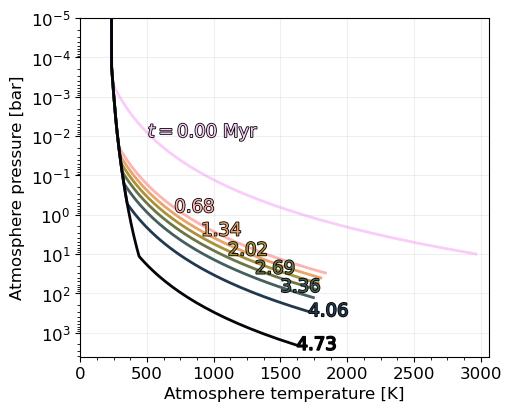

In [20]:
nlines = 8
al=1.0
lw=2

# Initialise plot
scale = 1.1
fig,ax = plt.subplots(1,1,figsize=(4.8*scale,4*scale))
ax.set_ylabel("Atmosphere pressure [bar]")
ax.set_xlabel("Atmosphere temperature [K]")
ax.invert_yaxis()
ax.set_yscale("log")

# Colour mapping
norm = mpl.colors.Normalize(vmin=times[0], vmax=times[-1])
sm = plt.cm.ScalarMappable(cmap=cm.batlowK_r, norm=norm)
sm.set_array([])

# Plot times 
tgt_times = np.linspace(0,times[-1],nlines)
plt_idx = []
for i,t in enumerate(tgt_times):
    i_near = np.argmin(np.abs(times - t))
    plt_idx.append(i_near)

# Plot data
for i,idx in enumerate(plt_idx):
    time = times[idx]
    c = sm.to_rgba(time)
    ax.plot(atm_t[idx], atm_p[idx], color=c, alpha=al, zorder=i, lw=lw)

    str_time = "%.2f"%time

    if i == 0:
        str_time = "$t=$%s Myr"%str_time

    str_idx = np.argmin(np.abs(atm_t[idx] - 500 - 200*i))
    txt = ax.text(atm_t[idx][str_idx]+5,atm_p[idx][str_idx], str_time, 
                    color=c, fontsize=13,
                    verticalalignment="center", horizontalalignment="left", zorder=999)
    txt.set_path_effects([pe.withStroke(linewidth=1.2, foreground='k')])
        

# Grid
ax.grid(alpha=0.2, zorder=2)
ax.set_xlim(0,np.amax(atm_t)+100)
ax.xaxis.set_minor_locator(MultipleLocator(base=125))

ax.set_ylim(np.amax(atm_p)*3, np.amin(atm_p)/3)
ax.yaxis.set_major_locator(LogLocator())
ax.set_ylim(top=np.amin(atm_p[-1]), bottom=np.amax(atm_p[-1]*2))


plt.show()

# Save plot
for fmt in ["pdf","png"]:
    fname = "output/plot_atmosphere_profiles.%s"%fmt
    fig.savefig(fname, bbox_inches='tight', dpi=300, transparent=True)

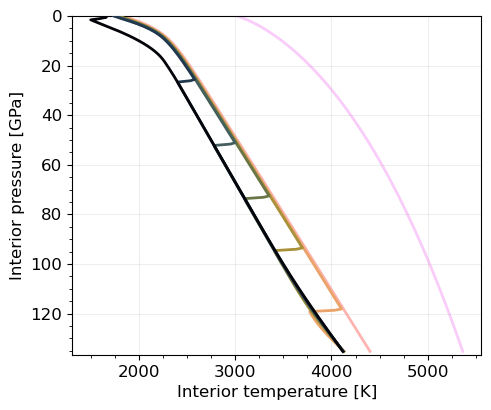

In [21]:
# Initialise plot
scale = 1.1
fig,ax = plt.subplots(1,1,figsize=(4.8*scale,4*scale))
ax.set_ylabel("Interior pressure [GPa]")
ax.set_xlabel("Interior temperature [K]")

# Plot data
for i,idx in enumerate(plt_idx):
    time = times[idx]
    c = sm.to_rgba(time)
    ax.plot(int_t[idx], int_p[idx], color=c, alpha=al, zorder=i, lw=lw)

# Grid
ax.grid(alpha=0.2, zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(250))

ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_ylim(top=np.amin(int_p[-1]), bottom=np.amax(int_p[-1]*1.01))

plt.show()

# Save plot
for fmt in ["pdf","png"]:
    fname = "output/plot_interior_profiles.%s"%fmt
    fig.savefig(fname, bbox_inches='tight', dpi=300, transparent=True)

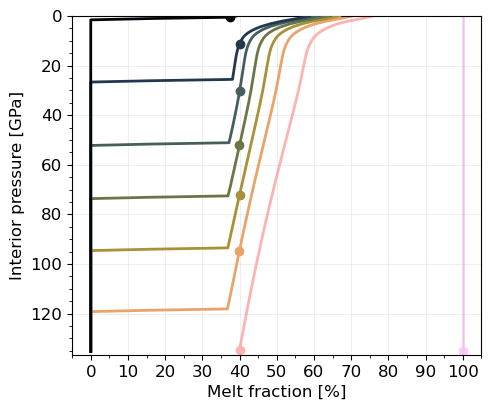

In [19]:
# Initialise plot
scale = 1.1
fig,ax = plt.subplots(1,1,figsize=(4.8*scale,4*scale))
ax.set_ylabel("Interior pressure [GPa]")
ax.set_xlabel("Melt fraction [%]")

# Plot data
for i,idx in enumerate(plt_idx):
    time = times[idx]
    c = sm.to_rgba(time)

    x = int_m[idx]
    y = int_p[idx]
    rfidx = int_f[idx]
    ax.plot(x,y, color=c, alpha=al, zorder=i, lw=lw)
    ax.scatter(x[rfidx],y[rfidx], color=c, zorder=i+1, marker='o')

# Grid
ax.grid(alpha=0.2, zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_ylim(top=np.amin(int_p[-1]), bottom=np.amax(int_p[-1]*1.01))

plt.show()

# Save plot
for fmt in ["pdf","png"]:
    fname = "output/plot_melting_profiles.%s"%fmt
    fig.savefig(fname, bbox_inches='tight', dpi=300, transparent=True)